# Translation simple ecoder-decocer over the b3 dataset

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
import copy
from contra_qa.plots.functions  import simple_step_plot
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu

% matplotlib inline

### Preparing data

In [2]:
df2 = pd.read_csv("data/boolean3_train.csv")
df2_test = pd.read_csv("data/boolean3_test.csv")


df2["text"] = df2["sentence1"] + df2["sentence2"] 
df2_test["text"] = df2_test["sentence1"] + df2_test["sentence2"] 

all_sentences = list(df2.text.values) + list(df2_test.text.values)

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [3]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label,text
8495,Milton went to Timisoara and Tulcea,Shawn didn't go to Tulcea,Milton went to Timisoara,Milton went to Tulcea,0,Milton went to Timisoara and TulceaShawn didn'...
8496,Alice has traveled to Giurgiu and Craiova,Alice didn't travel to Craiova,Alice has traveled to Giurgiu,Alice has traveled to Craiova,1,Alice has traveled to Giurgiu and CraiovaAlice...
8497,Blanche went to Slatina and Cluj-Napoca,Blanche didn't go to Bucharest,Blanche went to Slatina,Blanche went to Cluj-Napoca,0,Blanche went to Slatina and Cluj-NapocaBlanche...
8498,Nicole went to Reghin and Blaj,Nicole didn't go to Reghin,Nicole went to Reghin,Nicole went to Blaj,1,Nicole went to Reghin and BlajNicole didn't go...
8499,Sheryl went to Cluj-Napoca and Hunedoara,Sheryl didn't go to Hunedoara,Sheryl went to Cluj-Napoca,Sheryl went to Hunedoara,1,Sheryl went to Cluj-Napoca and HunedoaraSheryl...


In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf

After: ddddda capoeeeeeee ! ! aas fdf


In [6]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]
pairs_A_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_A.values)))
pairs_B_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_B.values)))
pairs_A_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A_val]
pairs_B_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B_val]


In [7]:
all_text_pairs = zip(all_sentences, all_sentences)
all_text_pairs = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in all_text_pairs]

In [8]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [9]:
MAX_LENGTH = 20


def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [10]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [11]:
_, _, training_pairs_A = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_A)
print()


input_lang, _, _ = prepareData("eng_enc",
                               "eng_dec",
                               all_text_pairs)

output_lang = copy.deepcopy(input_lang)

print()

_, _, valid_pairs_A = prepareData("eng_enc",
                                "eng_dec",
                                pairs_A_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 685
eng_dec 683

Read 11000 sentence pairs
Trimmed to 11000 sentence pairs
Counting words...
Counted words:
eng_enc 8149
eng_dec 8149

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 652
eng_dec 612


In [12]:
_, _, training_pairs_B = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_B)
print()
_, _, valid_pairs_B = prepareData("eng_enc",
                                "eng_dec",
                                pairs_B_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 685
eng_dec 683

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 652
eng_dec 608


### sentences 2 tensors

In [13]:
example = random.choice(training_pairs_A)
print(example)

('amanda went to hunedoara and baia mare', 'amanda went to hunedoara')


In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [15]:
indexesFromSentence(input_lang,example[0])

[1470, 37, 7, 102, 3, 33, 68]

In [16]:
indexesFromSentence(output_lang, example[1])

[1470, 37, 7, 102]

In [17]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [18]:
input_sen = tensorFromSentence(input_lang,example[0])
output_sen = tensorFromSentence(output_lang, example[1])

print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

tensor([[1470],
        [  37],
        [   7],
        [ 102],
        [   3],
        [  33],
        [  68],
        [   1]])

torch.Size([8, 1])
torch.int64
tensor([[1470],
        [  37],
        [   7],
        [ 102],
        [   1]])

torch.Size([5, 1])
torch.int64


In [19]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [20]:
input_sen, output_sen = tensorsFromPair(example)


print("input\n")
print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)

print("\noutput\n")
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

input

tensor([[1470],
        [  37],
        [   7],
        [ 102],
        [   3],
        [  33],
        [  68],
        [   1]])

torch.Size([8, 1])
torch.int64

output

tensor([[1470],
        [  37],
        [   7],
        [ 102],
        [   1]])

torch.Size([5, 1])
torch.int64


In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [22]:
hidden_size = 10
eng_enc_v_size = input_lang.n_words
eng_dec_v_size = output_lang.n_words

In [23]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
h0 = encoder.initHidden()
print("input_sen:", input_sen.shape, input_sen.dtype)
print("h0:", h0.shape, h0.dtype)

input_sen: torch.Size([8, 1]) torch.int64
h0: torch.Size([1, 1, 10]) torch.float32


In [24]:
max_length = MAX_LENGTH
encoder_outputs = torch.zeros(max_length,
                              encoder.hidden_size,
                              device=device)

input_length = input_sen.size(0)

for ei in range(input_length):
    output, hidden_enc = encoder(input_sen[ei], h0)
    h0 = hidden_enc
    encoder_outputs[ei] = output[0, 0]

print("output:", output.shape, output.dtype)
print("hidden_enc:", hidden_enc.shape, hidden_enc.dtype)

output: torch.Size([1, 1, 10]) torch.float32
hidden_enc: torch.Size([1, 1, 10]) torch.float32


In [25]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [26]:
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

decoder_input = torch.tensor([[SOS_token]], device=device)

decoder_hidden = hidden_enc

target_length = output_sen.size(0)

for di in range(target_length):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = output_sen[di]  # Teacher forcing
    print("decoder_output:", decoder_output.shape, decoder_output.dtype)
    print()
    print("decoder_hidden:", decoder_hidden.shape, decoder_hidden.dtype)    


decoder_output: torch.Size([1, 8149]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 8149]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 8149]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 8149]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 8149]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32


## Calculate loss over each token of the target language

In [27]:
learning_rate = 0.2
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [28]:
def train(input_tensor,
          target_tensor,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length,
          teacher_forcing_ratio=0.5):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    use_teacher_forcing = True

    if not random.random() < teacher_forcing_ratio:
        use_teacher_forcing = False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.topk(1)
            decoder_input = topone.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [29]:
def get_loss(input_tensor,
             target_tensor,
             encoder,
             decoder,
             criterion,
             max_length):

    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        _, topone = decoder_output.topk(1)
        decoder_input = topone.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break
    return loss.item() / target_length

Test get loss

In [30]:
valid_pairs = [tensorsFromPair(pair) for pair in valid_pairs_A]
valid_loss = []
for t in valid_pairs:
    input_sen, output_sen = t
    loss = get_loss(input_sen,
                    output_sen,
                    encoder,
                    decoder,
                    criterion,
                    MAX_LENGTH)
    valid_loss.append(loss)
print("mean loss", np.mean(valid_loss))

mean loss 9.020449376448374


In [31]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

Test train

0m 11s


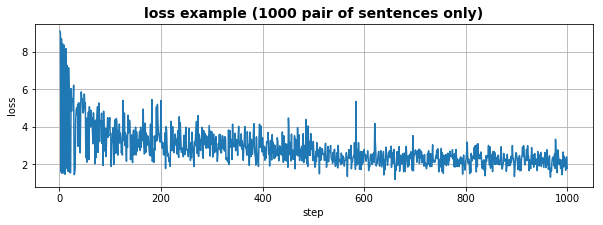

In [32]:
n_iters = 1000
training_pairs_little = [tensorsFromPair(random.choice(training_pairs_A)) for i in range(n_iters)]

losses = []
start = time.time()

for t in training_pairs_little:
    input_sen, output_sen = t    
    loss = train(input_sen,
                 output_sen,
                 encoder,
                 decoder,
                 encoder_optimizer,
                 decoder_optimizer,
                 criterion,
                 max_length=MAX_LENGTH)
    losses.append(loss)

print(timeSince(start))

simple_step_plot([losses],
                 "loss",
                 "loss example ({} pair of sentences only)".format(n_iters),
                 "loss_example.png",
                  figsize=(10,3))

In [33]:
def trainIters(encoder,
               decoder,
               n_iters,
               pairs,
               valid_pairs,
               encoder_path,
               decoder_path,
               batch_size=32,
               status_every=100,
               learning_rate=0.01,
               teacher_forcing_ratio=0.5):

    plot_losses = []
    old = 0
    start = time.time()
    all_loss = []
    valid_loss = float("inf")
    
    

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    for i, t in enumerate(training_pairs):
        input_sen, output_sen = t
        loss = train(input_sen,
                     output_sen,
                     encoder,
                     decoder,
                     encoder_optimizer,
                     decoder_optimizer,
                     criterion,
                     max_length=MAX_LENGTH,
                     teacher_forcing_ratio=teacher_forcing_ratio)
        plot_losses.append(loss)

        if i % status_every == 0 and i != 0:
            valid_batch = [tensorsFromPair(random.choice(valid_pairs))
                           for i in range(batch_size)]
            batch_loss = 0
            for t in valid_batch:
                input_sen, output_sen = t
                batch_loss += get_loss(input_sen,
                                       output_sen,
                                       encoder,
                                       decoder,
                                       criterion,
                                       MAX_LENGTH)
            current_valid_loss = batch_loss / batch_size
            
            if current_valid_loss < valid_loss:
                valid_loss = current_valid_loss
                torch.save(encoder.state_dict(), encoder_path)
                torch.save(decoder.state_dict(), decoder_path)
            print("mean training loss = {:.2f}".format(np.mean(plot_losses)))
            print("mean valid loss = {:.2f}".format(current_valid_loss))
            print("time in {} steps:".format(status_every), timeSince(start))
            print()
#             simple_step_plot([plot_losses],
#                              "loss",
#                              "loss plot (from {} to {})".format(old, i),
#                              "loss_example.png",
#                              figsize=(10, 3))
            all_loss += plot_losses
            plot_losses = []
            old = i
            start = time.time()
    
    simple_step_plot([all_loss],
                     "loss",
                     "loss over training" ,
                     "loss_example.png",
                     figsize=(15, 3))


## translating

In [35]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a non trained model

In [36]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

np.random.shuffle(training_pairs_A)

In [37]:
for t in training_pairs_A[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()


input_sentence : brittany went to turda and blaj
neural translation : aradanna bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime
reference translation : brittany went to turda <EOS>
blue score = 0.00

input_sentence : janie and geraldine have traveled to vaslui
neural translation : aradanna bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime bucharestjaime
reference translation : janie has traveled to vaslui <EOS>
blue score = 0.00

input_sentence : glen and claire went to deva
neural translation : aradanna reghinolivia slobozialauren lee tu

## Training some models and observing its translation

In [38]:
def save_translation(pairs, encoder, decoder, max_length, out_path):
    with open(out_path, "w") as file:
        file.write("source,candidate,reference,blue,accuracy\n")        
        for tuple_ in pairs:
            source, reference = tuple_
            candidate = translate(encoder,
                                  decoder,
                                  source,
                                  max_length=max_length)
            reference =  reference + ' <EOS>'
            blue = sentence_bleu([reference.split(" ")], candidate.split(" "))
            if blue >= 0.95:
                acc = 1
            else:
                acc = 0
            line = source + ","
            line += candidate + ","
            line += reference + ","
            line += "{:.3f},".format(blue)
            line += "{}\n".format(acc)
            file.write(line)

Test save_translation

In [39]:
save_translation(training_pairs_A[0:3],
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "temp.csv")

### Training 1

mean training loss = 3.70
mean valid loss = 3.19
time in 200 steps: 0m 54s

mean training loss = 2.54
mean valid loss = 2.32
time in 200 steps: 0m 55s

mean training loss = 2.27
mean valid loss = 2.25
time in 200 steps: 1m 15s

mean training loss = 1.97
mean valid loss = 1.84
time in 200 steps: 1m 12s

mean training loss = 1.67
mean valid loss = 1.55
time in 200 steps: 1m 14s

mean training loss = 1.49
mean valid loss = 1.52
time in 200 steps: 1m 12s

mean training loss = 1.44
mean valid loss = 1.47
time in 200 steps: 1m 15s

mean training loss = 1.43
mean valid loss = 1.41
time in 200 steps: 1m 22s

mean training loss = 1.36
mean valid loss = 1.45
time in 200 steps: 1m 18s

mean training loss = 1.36
mean valid loss = 1.45
time in 200 steps: 1m 9s

mean training loss = 1.38
mean valid loss = 1.39
time in 200 steps: 1m 10s

mean training loss = 1.35
mean valid loss = 1.46
time in 200 steps: 1m 6s

mean training loss = 1.33
mean valid loss = 1.40
time in 200 steps: 1m 5s

mean training l

/home/felsal/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


mean training loss = 1.28
mean valid loss = 1.37
time in 200 steps: 1m 32s

mean training loss = 1.26
mean valid loss = 1.38
time in 200 steps: 1m 16s

mean training loss = 1.25
mean valid loss = 1.40
time in 200 steps: 1m 15s

mean blue score over training data = 0.711
mean acc over training data = 0.014


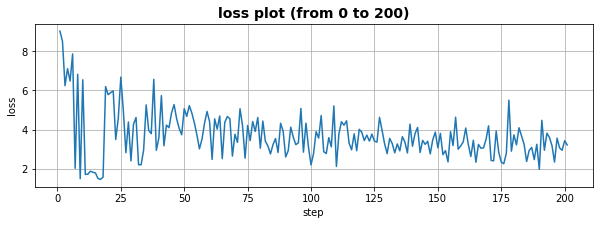

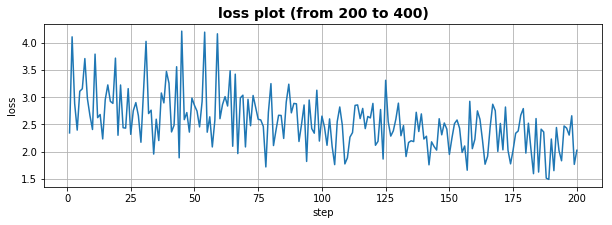

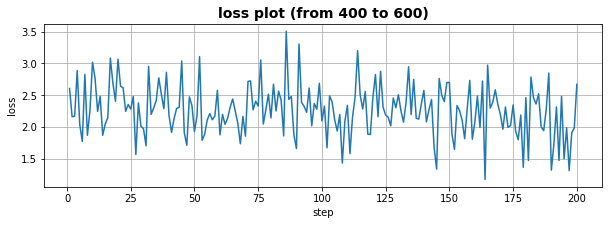

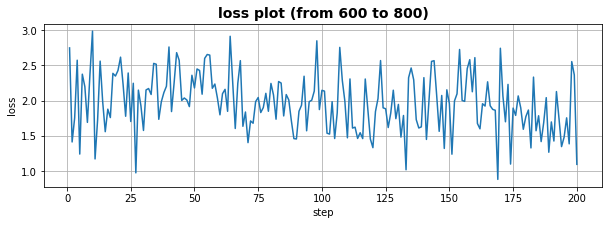

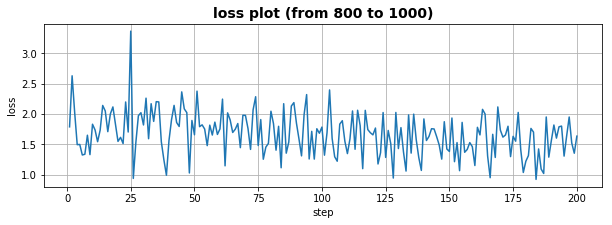

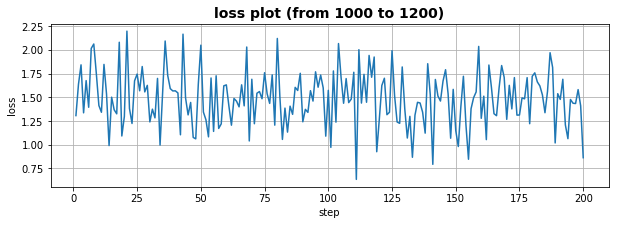

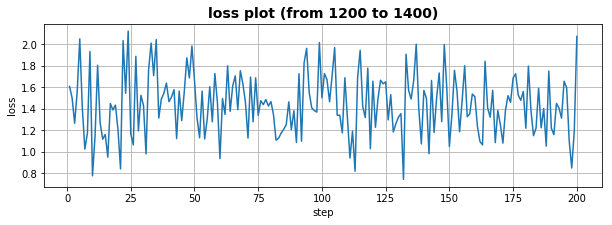

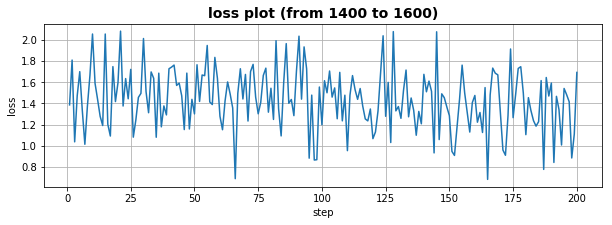

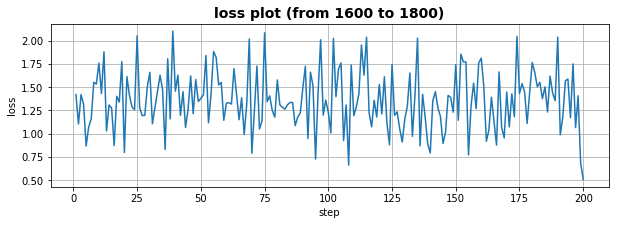

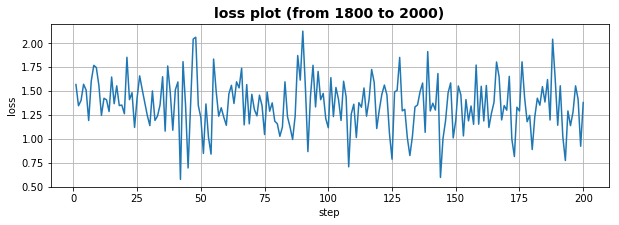

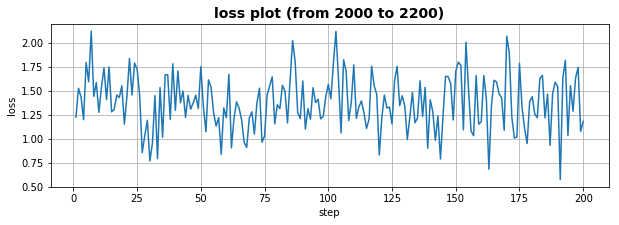

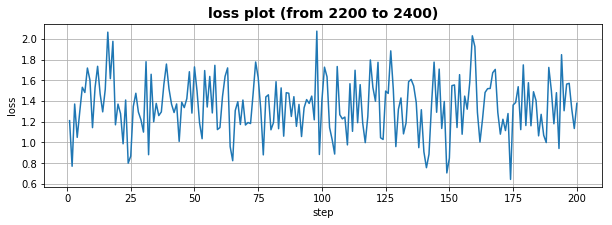

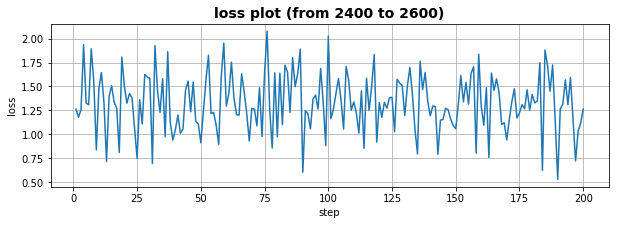

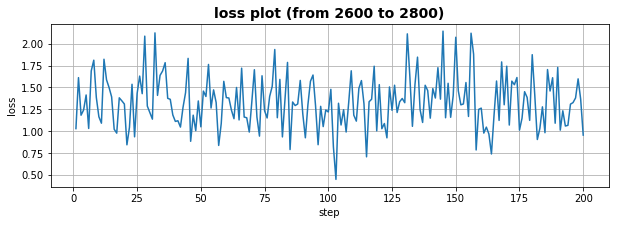

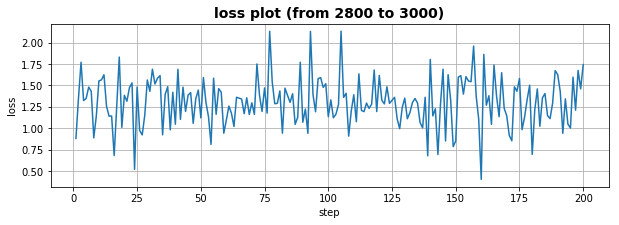

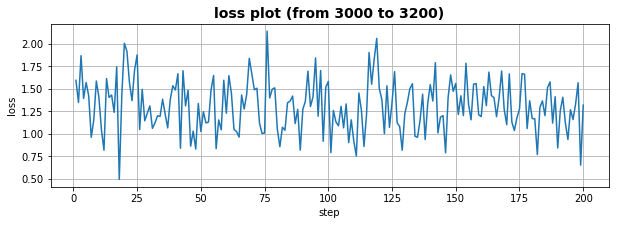

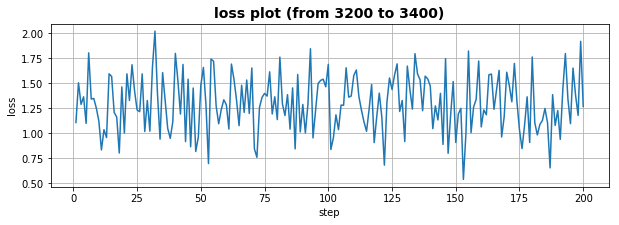

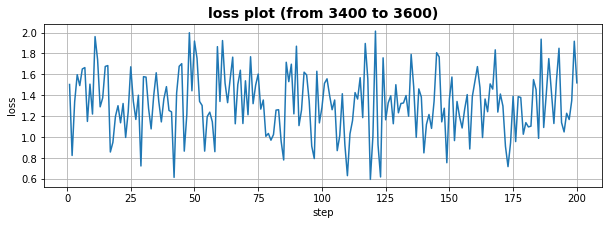

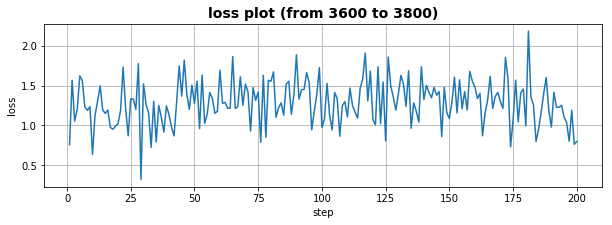

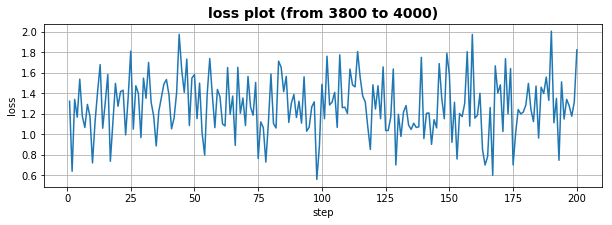

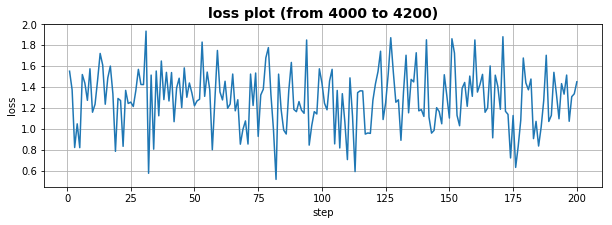

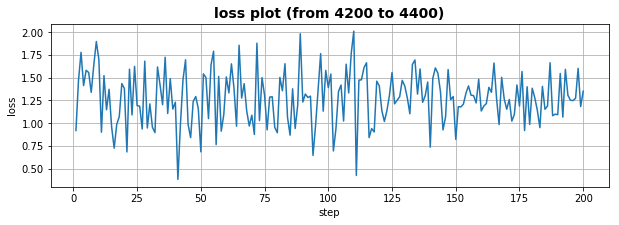

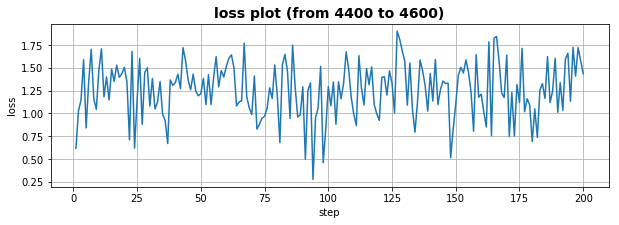

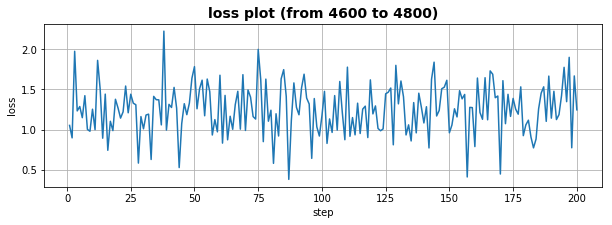

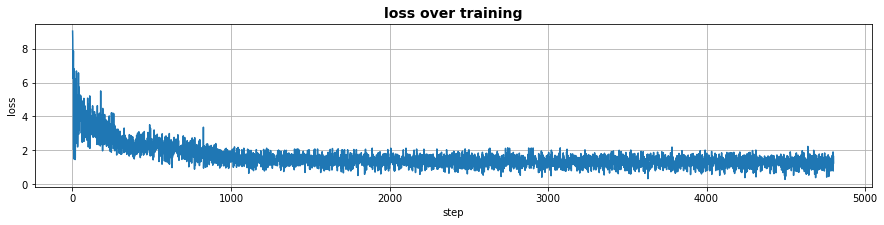

In [51]:
hidden_size = 500

encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=training_pairs_A,
           valid_pairs=valid_pairs_A,
           encoder_path="b3_encoder1.pkl",
           decoder_path="b3_decoder1.pkl",
           status_every=200,
           learning_rate=0.02,
           teacher_forcing_ratio=0.2)


save_translation(training_pairs_A,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "b3_training1.csv")

df_results = pd.read_csv("b3_training1.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

### Training 2

mean training loss = 3.72
mean valid loss = 2.94
time in 200 steps: 1m 0s

mean training loss = 2.61
mean valid loss = 2.27
time in 200 steps: 1m 3s

mean training loss = 1.97
mean valid loss = 1.70
time in 200 steps: 1m 7s

mean training loss = 1.57
mean valid loss = 1.52
time in 200 steps: 1m 20s

mean training loss = 1.51
mean valid loss = 1.47
time in 200 steps: 1m 13s

mean training loss = 1.47
mean valid loss = 1.56
time in 200 steps: 1m 16s

mean training loss = 1.44
mean valid loss = 1.38
time in 200 steps: 1m 13s

mean training loss = 1.39
mean valid loss = 1.52
time in 200 steps: 1m 6s

mean training loss = 1.40
mean valid loss = 1.50
time in 200 steps: 1m 6s

mean training loss = 1.37
mean valid loss = 1.43
time in 200 steps: 0m 58s

mean training loss = 1.37
mean valid loss = 1.45
time in 200 steps: 1m 4s

mean training loss = 1.36
mean valid loss = 1.39
time in 200 steps: 1m 6s

mean training loss = 1.35
mean valid loss = 1.44
time in 200 steps: 1m 8s

mean training loss =

/home/felsal/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


mean training loss = 1.27
mean valid loss = 1.29
time in 200 steps: 1m 5s

mean training loss = 1.28
mean valid loss = 1.35
time in 200 steps: 1m 6s

mean training loss = 1.28
mean valid loss = 1.35
time in 200 steps: 1m 3s



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over training data = 0.638
mean acc over training data = 0.001


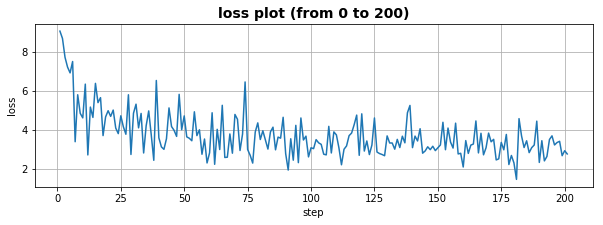

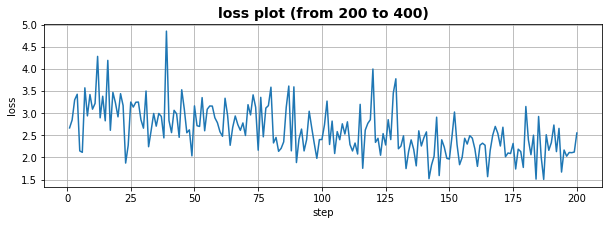

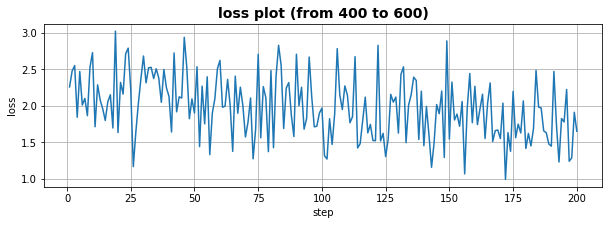

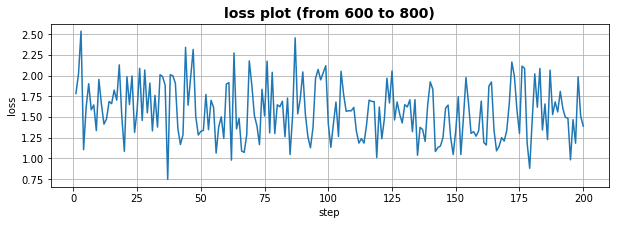

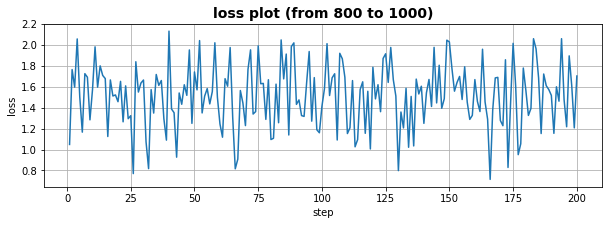

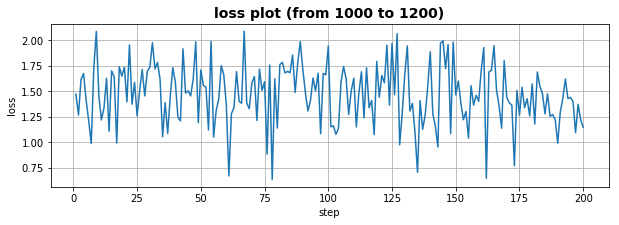

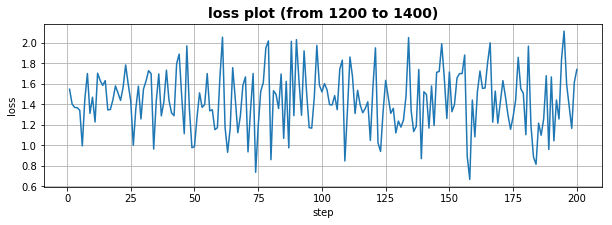

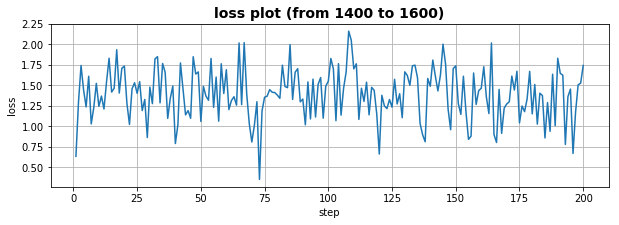

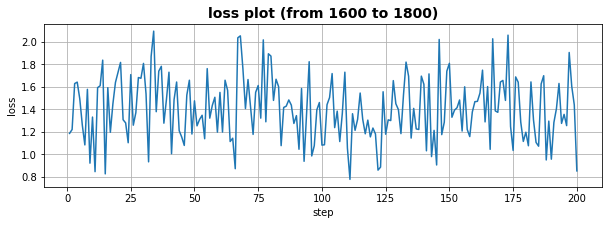

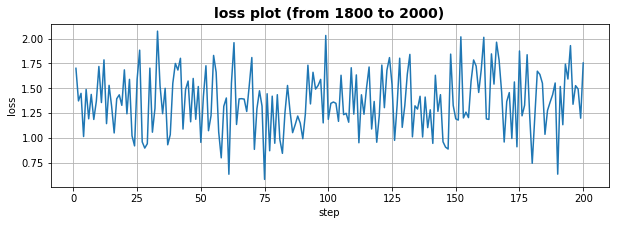

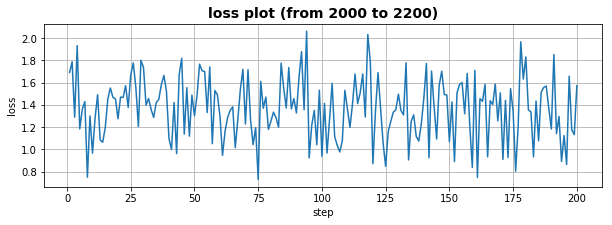

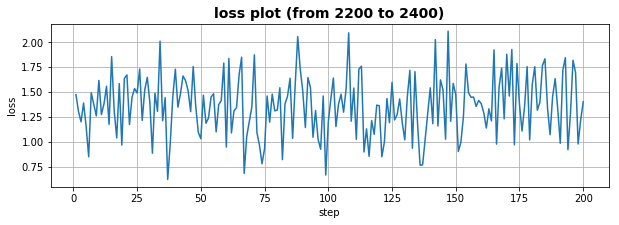

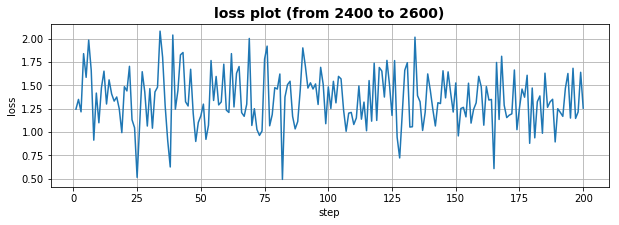

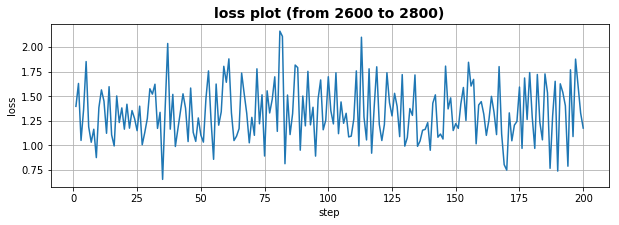

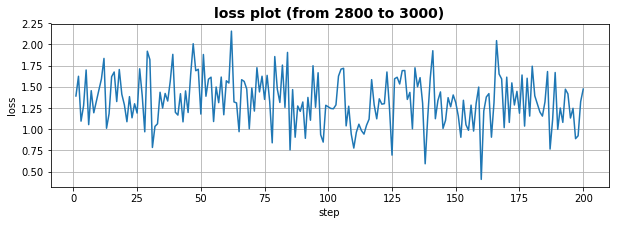

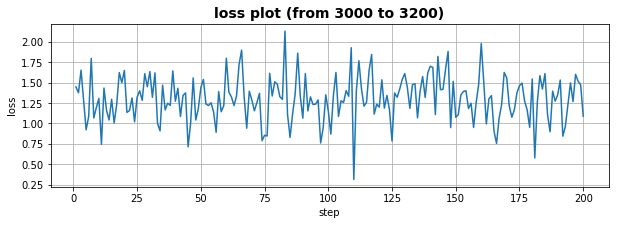

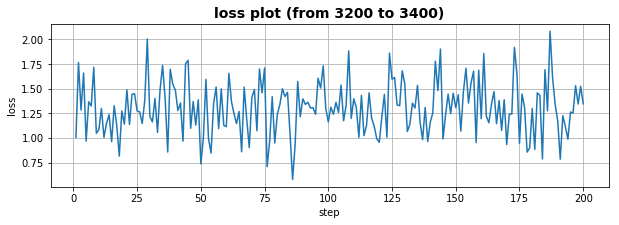

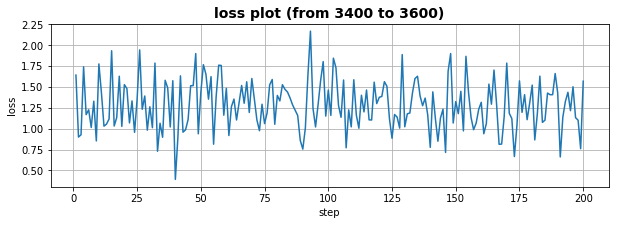

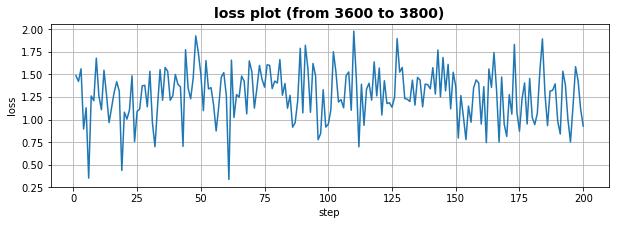

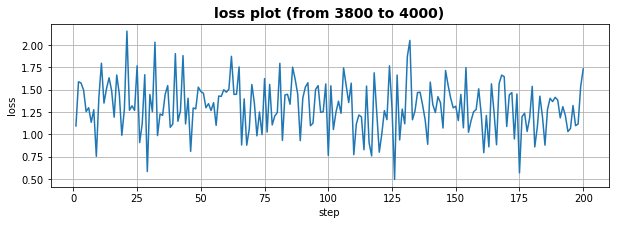

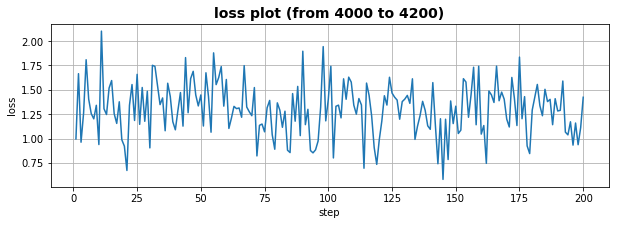

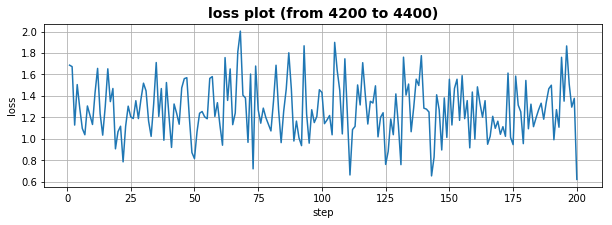

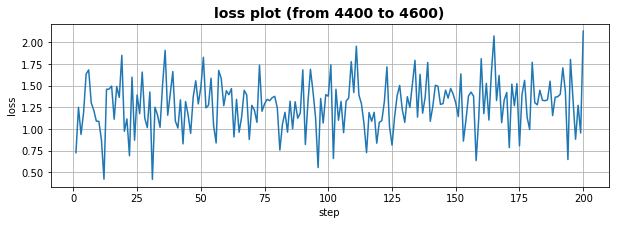

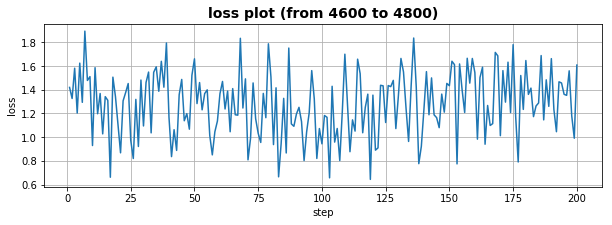

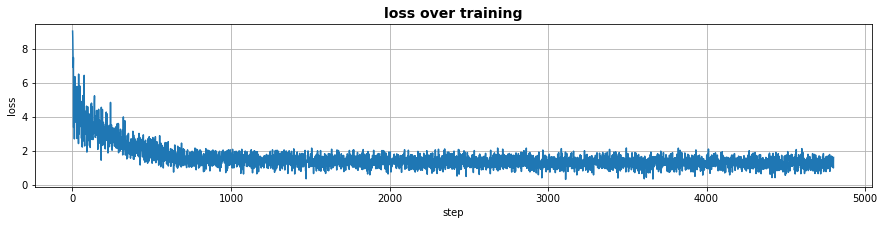

In [52]:
hidden_size = 500

encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=training_pairs_B,
           valid_pairs=valid_pairs_B,
           encoder_path="b3_encoder2.pkl",
           decoder_path="b3_decoder2.pkl",
           status_every=200,
           learning_rate=0.02,
           teacher_forcing_ratio=0.5)


save_translation(training_pairs_A,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "b3_training2.csv")

df_results = pd.read_csv("b3_training2.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

### Evaluating the trained models

### and A

In [45]:
hidden_size = 500

encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

encoder.load_state_dict(torch.load("b3_encoder1.pkl"))
decoder.load_state_dict(torch.load("b3_decoder1.pkl"))

In [46]:
save_translation(training_pairs_A,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "b3_training1.csv")

df_results = pd.read_csv("b3_training1.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


mean blue score over training data = 0.573
mean acc over training data = 0.000


In [ ]:
save_translation(valid_pairs_A,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "b3_valid1.csv")

df_results = pd.read_csv("b3_valid1.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

### and B

In [53]:
hidden_size = 500

encoder = EncoderRNN(eng_enc_v_size, hidden_size)
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

encoder.load_state_dict(torch.load("b3_encoder2.pkl"))
decoder.load_state_dict(torch.load("b3_decoder2.pkl"))

In [54]:
save_translation(training_pairs_B,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "b3_training2.csv")

df_results = pd.read_csv("b3_training2.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

mean blue score over training data = 0.710
mean acc over training data = 0.010


In [55]:
save_translation(valid_pairs_B,
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "b3_valid2.csv")

df_results = pd.read_csv("b3_valid2.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

mean blue score over valid data = 0.709
mean acc over valid data = 0.002
